<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# setup git
!git clone https://github.com/zsteve/wtf
!pip install tensorly
!pip install pot

fatal: destination path 'wtf' already exists and is not an empty directory.


In [1]:
import sys
sys.path.insert(0, "/home/szhangubcmath/wtf/src")
import wtf

In [2]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

np.random.seed(0)

In [11]:
# 8x8 digits dataset
M = 1500
N = 10
data_digits = sklearn.datasets.load_digits(n_class = N)
idx = np.random.choice(np.arange(data_digits.data.shape[0]), size = M)
data_digits.data = data_digits.data[idx]
data_digits.images = data_digits.images[idx]
data_digits.target = data_digits.target[idx]
target = data_digits.target

perm = np.random.permutation(M)
train_idx = perm[:750]
test_idx = perm[750:]

sizex, sizey = (8, 8)
X = tl.tensor([wtf.normalise(x) for x in data_digits.images], dtype = tl_dtype)
# X = X/X.sum(-1).sum(-1).mean()

X_test = X[test_idx]
X_train = X[train_idx]

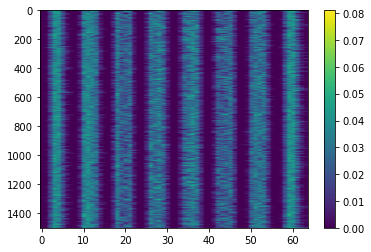

In [12]:
plt.imshow(tl.unfold(X, 0))
plt.axis("auto")
plt.colorbar()

In [13]:
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [14]:
# now pick multilinear rank
d = 3
r = [25, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

RAND_STATE = 0

# initialise using SVD
factor_cp = tl.decomposition.non_negative_parafac(X_train, rank = r[0], n_iter_max = 0, init = "svd", random_state = RAND_STATE)
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0_train = X_train.to(device)

###

# good params
# n_iter = 10
# lr = np.ones(n_iter)*0.1
# lamda = np.array([np.ones(3), ]*n_iter)*10
# optim_modes = [0, ]
# rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.01
# eps = np.array([np.ones(3), ]*n_iter)*0.01
n_iter = 10
lr = np.ones(n_iter)
lamda = np.array([np.ones(3), ]*n_iter)*5
optim_modes = [0, ]
rho = np.array([np.array([1e-2, 1e-2, 1e-2]), ]*n_iter)
eps = np.array([np.ones(3), ]*n_iter)*0.01

In [15]:
A[0] = (A[0].T/A[0].sum(1)).T
A[1] = A[1]/A[1].sum(0)
A[2] = A[2]/A[2].sum(0)

In [16]:
max_iter, print_inter, check_iter, tol, unbal = (250, 10, 10, 1e-2, True)
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_train, 0, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal, norm = "row")
    wtf.solve(m0, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m0.U[0].max())
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_train, 1, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal, norm = "col")
    wtf.solve(m1, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m1.U[0].max())
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0_train, 2, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal, norm = "col")
    wtf.solve(m2, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m2.U[0].max())
    A[2] = m2.compute_primal_variable().detach()
    # print("Core tensor")
    # m = wtf.CoreModel(X0_train, None, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", C_full = C_full, device = device, unbal = unbal)
    # wtf.solve(m, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 22.064940
i = 10 	 dual = 21.729223
tensor(0.8649, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 1
i = 0 	 dual = 20.079832
i = 10 	 dual = 14.000377
i = 20 	 dual = 13.756474
i = 30 	 dual = 13.705461
tensor(0.6487, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 2
i = 0 	 dual = 25.193338
i = 10 	 dual = 22.158917
i = 20 	 dual = 22.132291
tensor(0.4352, device='cuda:0', grad_fn=<MaxBackward1>)
Block iteration  1
Mode 0
i = 0 	 dual = 42.445931
i = 10 	 dual = 42.219125
tensor(0.6929, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 1
i = 0 	 dual = 27.346340
i = 10 	 dual = 25.473704
i = 20 	 dual = 25.383598
i = 30 	 dual = 25.359018
tensor(0.4472, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 2
i = 0 	 dual = 27.954773
i = 10 	 dual = 27.219276
i = 20 	 dual = 27.206239
tensor(0.2671, device='cuda:0', grad_fn=<MaxBackward1>)
Block iteration  2
Mode 0
i = 0 	 dual = 46.553808
i = 10 	 dual = 46.489675
tensor(0.3699, device='cuda:0', grad_fn=<MaxB

In [17]:
X_hat_train = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp_train = tl.decomposition.non_negative_parafac(X_train, rank = r[0], init = "svd", n_iter_max = 500, random_state = RAND_STATE, tol = 1e-12)
X_cp_train = tl.cp_tensor.cp_to_tensor(factor_cp_train)

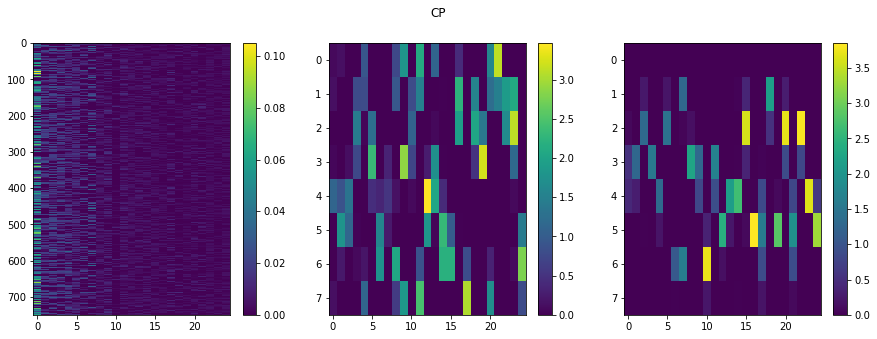

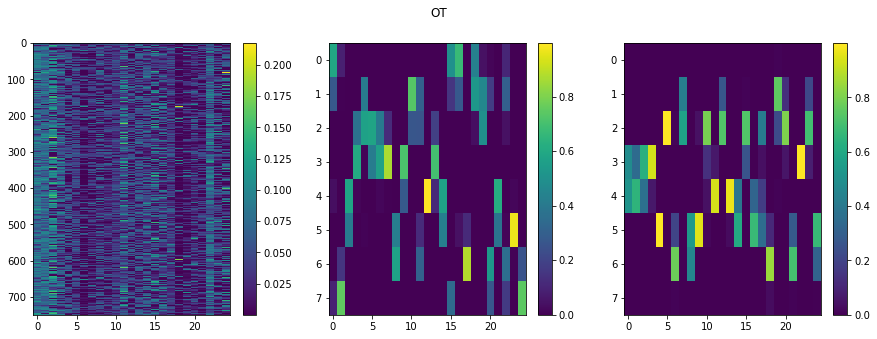

In [18]:
plt.figure(figsize = (15, 5))
plt.suptitle("CP")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp_train.factors[i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (15, 5))
plt.suptitle("OT")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

(-0.5, 624.5, 24.5, -0.5)

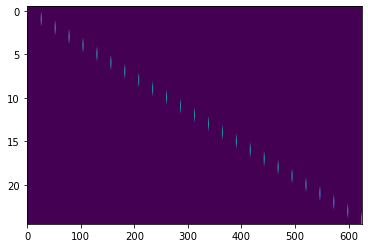

In [19]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

(-0.5, 749.5, 63.5, -0.5)

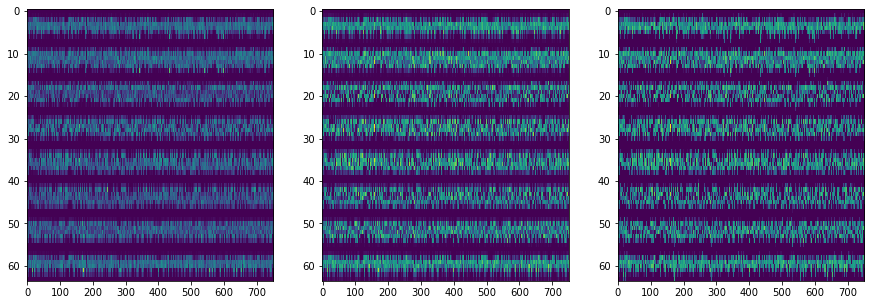

In [20]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_hat_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.imshow(X_cp_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.imshow(X_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")

In [21]:
d_ot = np.array([ot.emd2(wtf.normalise(X_hat_train[i, :, :].reshape(-1).double()), wtf.normalise(X_train[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])
d_baseline = np.array([ot.emd2(wtf.normalise(X_cp_train[i, :, :].reshape(-1).double()), wtf.normalise(X_train[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])

In [22]:
d_ot.mean(), d_baseline.mean()

(0.008343176907312703, 0.008973246958758705)

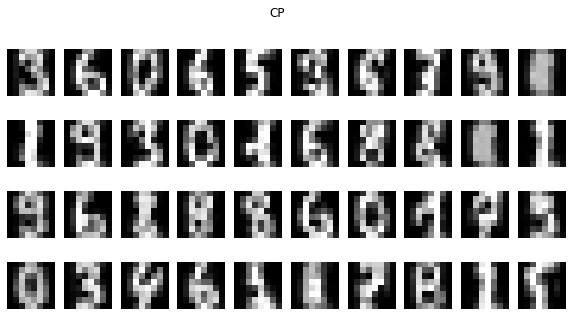

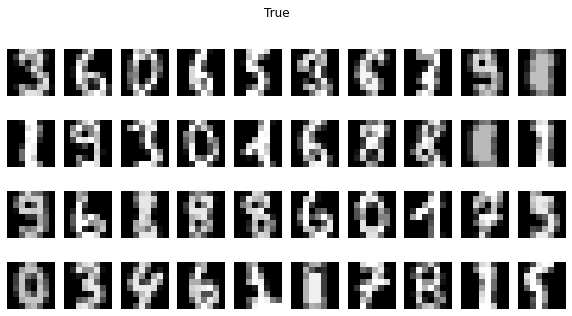

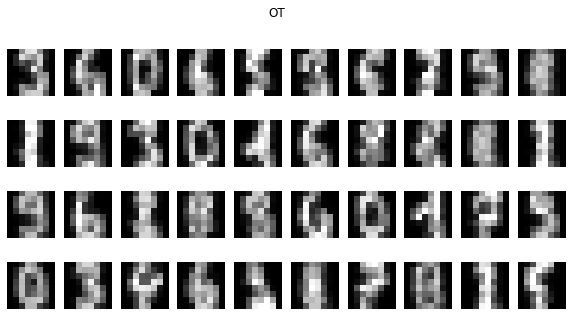

In [23]:
vmax = np.quantile(X_train, 0.95)
perm = np.random.permutation(X_train.shape[0])

plt.figure(figsize = (10, 5))
plt.suptitle("CP")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_cp_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

plt.figure(figsize = (10, 5))
plt.suptitle("True")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

plt.figure(figsize = (10, 5))
plt.suptitle("OT")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_hat_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

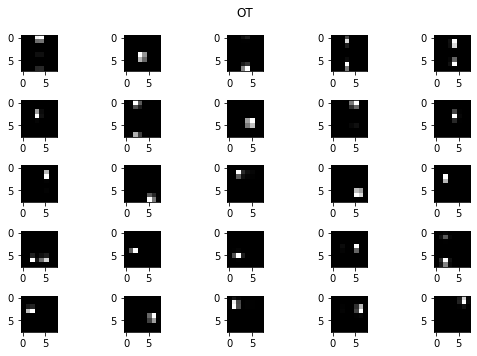

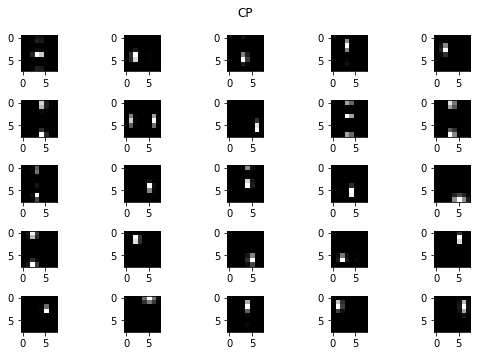

In [24]:
def outer(u, v):
    return u.reshape(-1, 1) * v.reshape(1, -1)

plt.figure(figsize = (7.5, 5))
plt.suptitle("OT")
perm = np.array(np.argsort(A[0].sum(0).cpu()))[::-1]
for i in range(r[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(outer(A[1][:, perm[i]], A[2][:, perm[i]]).cpu(), cmap = "gray")
plt.tight_layout()

plt.figure(figsize = (7.5, 5))
plt.suptitle("CP")
perm = np.array(np.argsort(factor_cp_train.factors[0].sum(0)))[::-1]
for i in range(r[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(outer(factor_cp_train.factors[1][:, perm[i]], factor_cp_train.factors[2][:, perm[i]]).cpu(), cmap = "gray")
plt.tight_layout()

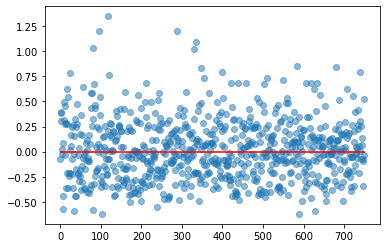

In [25]:
plt.scatter(np.arange(d_ot.shape[0]), (d_ot - d_baseline)/d_baseline, alpha = 0.5)
plt.hlines(0, 0, d_ot.shape[0], color = "red")

In [26]:
from sklearn import cluster
kmeans = sklearn.cluster.KMeans(n_clusters = 10, n_init = 25)
def get_nmi_avg(M):
    clust = kmeans.fit_predict(M)
    return sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust)

In [27]:
nmi_ot = np.array([get_nmi_avg(A[0].cpu()) for _ in range(10)])
nmi_cp = np.array([get_nmi_avg(factor_cp_train.factors[0]) for _ in range(10)])
nmi_ot, nmi_cp

(array([0.65605092, 0.66750244, 0.65496661, 0.65464912, 0.67441938,
        0.66150035, 0.6523645 , 0.65285795, 0.65452046, 0.66628828]),
 array([0.44923874, 0.44241331, 0.44250951, 0.45236369, 0.44547213,
        0.44797946, 0.43940125, 0.44193683, 0.45860094, 0.44358834]))

In [28]:
nmi_ot.mean(), nmi_cp.mean()

(0.6595119999081207, 0.4463504186012188)

In [29]:
# SVM classifier
from sklearn import svm
clf = svm.SVC()
clf.fit(A[0].cpu(), target[train_idx])

# fit new coefficients
A_test = [tl.ones((X_test.shape[0], r[0]), dtype = tl_dtype), tl.copy(A[1]), tl.copy(A[2])]
m0 = wtf.FactorsModel(tl.tensor(X_test, dtype = tl_dtype).cuda(), 0, None, S, A_test, rho[0, :], eps[0, :], lamda[0, :], 
                         optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
wtf.solve(m0, lr = lr[0], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = 1e-4)
A_test[0] = m0.compute_primal_variable().detach()

/opt/conda/lib/python3.7/site-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


i = 0 	 dual = 59.047329
i = 10 	 dual = 58.962431
i = 20 	 dual = 58.960200
i = 30 	 dual = 58.959740
i = 40 	 dual = 58.959545


In [30]:
err_train = (clf.predict(A[0].cpu()) != target[train_idx]).mean() # train error
err_test = (clf.predict(A_test[0].cpu()) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.008  err_test =  0.013333333333333334


In [31]:
# SVM classifier for Frobenius-CP
clf_cp = svm.SVC()
clf_cp.fit(factor_cp_train.factors[0], target[train_idx])
cp_fitter = sklearn.decomposition.NMF()
cp_fitter.n_components_ = r[0]
cp_fitter.components_ = np.array(tl.tenalg.khatri_rao(factor_cp_train.factors[1:])).T
coeffs = cp_fitter.transform(tl.unfold(X_test, 0))
err_train = (clf_cp.predict(factor_cp_train.factors[0]) != target[train_idx]).mean() # train error
err_test = (clf_cp.predict(coeffs) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.048  err_test =  0.064


In [32]:
# SVM classifier for PCA
pca = sklearn.decomposition.PCA(n_components = r[0])
X_train_pca = pca.fit_transform(tl.unfold(X_train, 0))
X_test_pca = pca.transform(tl.unfold(X_test, 0))
clf_pca = svm.SVC()
clf_pca.fit(X_train_pca, target[train_idx])
err_train = (clf_pca.predict(X_train_pca) != target[train_idx]).mean() # train error
err_test = (clf_pca.predict(X_test_pca) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.004  err_test =  0.013333333333333334
